## Pytorch神经网络工具箱

### 常用神经网络层
#### 1. 全连接层
实现操作：$$\bf y = W^TX+b$$

In [1]:
# 参考
import torch
from torch import nn
class Linear(nn.Module): # 继承nn.Module
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__() # 等价于nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
    
    def forward(self, x):
        x = x.mm(self.w) # x.@(self.w)
        return x + self.b.expand_as(x)

In [2]:
import torch
from torch import nn

input = torch.ones(3,5)
layer = nn.Linear(5,4)
output = layer(input)
print(output)
for name, parameter in layer.named_parameters():
    print(name, parameter) # w and b 

tensor([[ 0.5446, -0.6554,  0.3682, -0.5308],
        [ 0.5446, -0.6554,  0.3682, -0.5308],
        [ 0.5446, -0.6554,  0.3682, -0.5308]])
weight Parameter containing:
tensor([[-0.2122,  0.2314,  0.1573, -0.1482,  0.3047],
        [-0.4138, -0.1137,  0.3226, -0.1950, -0.1396],
        [-0.2562,  0.3011, -0.2532,  0.1490,  0.2473],
        [-0.0636, -0.0296,  0.1023, -0.2198,  0.1246]])
bias Parameter containing:
tensor([ 0.2115, -0.1160,  0.1802, -0.4446])


为方便用户使用，PyTorch实现了神经网络中绝大多数的layer，这些layer都继承于nn.Module，封装了可学习参数`parameter`，并实现了forward函数，且很多都专门针对GPU运算进行了CuDNN优化，其速度和性能都十分优异。具体可参照官方文档，阅读文档时应主要关注以下几点：

- 构造函数的参数，如nn.Linear(in_features, out_features, bias)，需关注这三个参数的作用。
- 属性，可学习参数，子module。如nn.Linear中有`weight`和`bias`两个可学习参数，不包含子module。
- 输入输出的形状，如nn.linear的输入形状是(N, input_features)，输出为(N，output_features)，N是batch_size。

这些自定义layer对输入形状都有假设：输入的不是单个数据，而是一个batch。若想输入一个数据，则必须调用`unsqueeze(0)`函数将数据伪装成batch_size=1的batch

#### 2 卷积层
实际使用中可分为一维(1D)、二维(2D)、三维（3D） $$\bf y = W * X + b$$

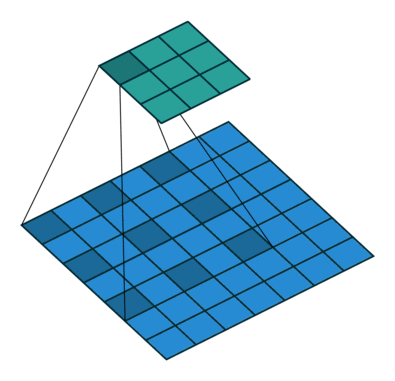
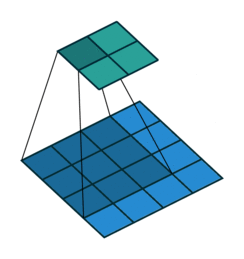
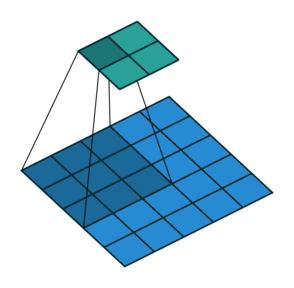
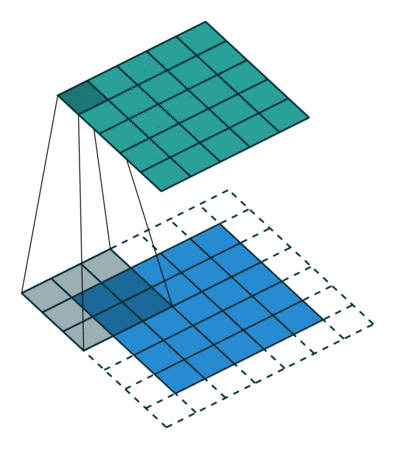

In [4]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn

lena = mpimg.imread('/home/kesci/input/lena5449/lena.jpg')
plt.imshow(lena)


<Figure size 432x288 with 1 Axes>

In [5]:
# 输入是一个batch，batch_size＝1
input = torch.from_numpy(lena[:,:,0].astype('float32')).unsqueeze(0).unsqueeze(0)

# 锐化卷积核
kernel = torch.ones(3, 3)/9.
kernel[1][1] = -1
# class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, stride = 1, padding=1, dilation=1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)
out = conv(input)
print(input.shape)
print(out.shape)
plt.imshow(out.data.squeeze(0).squeeze(0) > 0 ,cmap='gray')


torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


<Figure size 432x288 with 1 Axes>

#### 3 池化层
池化层可以看作是一种特殊的卷积层，用来降采样。但池化层没有可学习参数，其weight是固定的。

In [6]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())
out = pool(input)
print(input.shape)
print(out.shape)
plt.imshow(out.data.squeeze(0).squeeze(0) ,cmap='gray')


torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 256, 256])


<Figure size 432x288 with 1 Axes>

#### 4 批归一化层
BatchNorm：分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层。
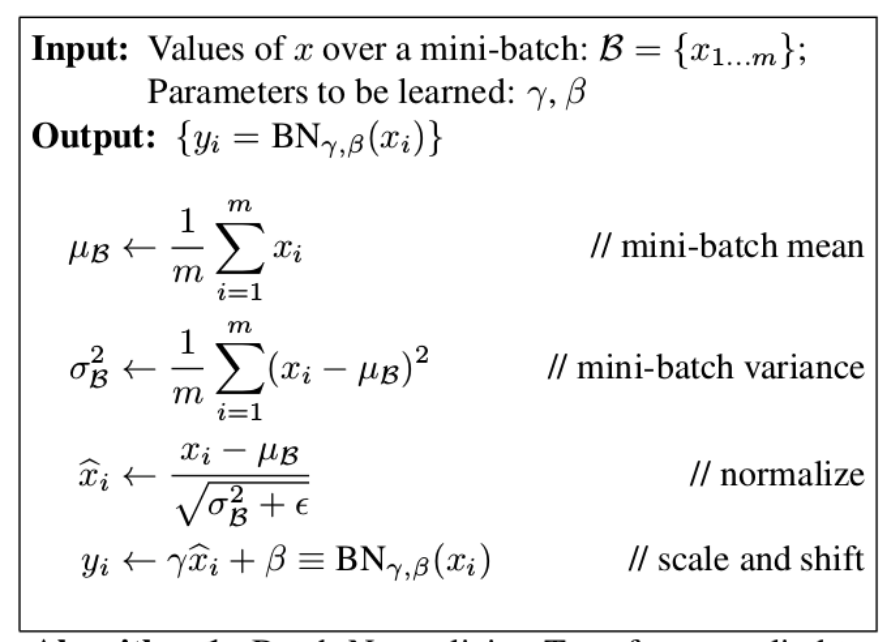

In [7]:
# 输入 batch_size=2，维度3
input = torch.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input)
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = torch.ones(4) * 4
bn.bias.data = torch.zeros(4)
print(h)
bn_out = bn(h)
print(bn_out)
# 注意输出的均值和方差
# 方差是标准差的平方，计算无偏方差分母会减1
# 使用unbiased=False 分母不减1
print(bn_out.mean(0))
print(bn_out.var(0, unbiased=False))

tensor([[ 0.5699, -0.4905,  0.1478,  0.0319],
        [ 0.2887, -0.7938,  0.5048,  0.1771]])
tensor([[ 3.9990,  3.9991, -3.9994, -3.9962],
        [-3.9990, -3.9991,  3.9994,  3.9962]])
tensor(1.00000e-07 *
       [ 4.7684, -3.5763, -2.3842,  0.0000])
tensor([ 15.9919,  15.9930,  15.9950,  15.9697])


#### 5 Dropout
Dropout：dropout层，用来防止过拟合，同样分为1D、2D和3D。  
注意输出值会乘一个系数(1/p)，保证能量一致

In [8]:
m = nn.Dropout2d(p=0.5)
input = torch.randn(1, 5, 1, 1)
output = m(input)
print(input)
print(output)

tensor([[[[-1.4958]],

         [[ 0.5730]],

         [[-1.1983]],

         [[ 0.2553]],

         [[-1.0460]]]])
tensor([[[[-0.0000]],

         [[ 1.1460]],

         [[-2.3966]],

         [[ 0.5107]],

         [[-2.0920]]]])


#### 6 激活函数
PyTorch实现了常见的激活函数，其具体的接口信息可参见官方文档，这些激活函数可作为独立的layer使用。

最常见的激活函数Relu其数学表达式为：
$$ReLU(x)=max(0,x)$$

In [9]:
m = nn.ReLU()
input = torch.randn(1, 1, 3, 3)
output = m(input)
print(input)
print(output)

tensor([[[[ 0.5280, -0.8092, -0.8736],
          [ 0.3109, -1.2260,  0.4465],
          [ 1.5318, -0.5049,  1.7744]]]])
tensor([[[[ 0.5280,  0.0000,  0.0000],
          [ 0.3109,  0.0000,  0.4465],
          [ 1.5318,  0.0000,  1.7744]]]])


注： ReLU函数有个inplace参数，如果设为True，它会把输出直接覆盖到输入中，这样可以节省内存/显存。之所以可以覆盖是因为在计算ReLU的反向传播时，只需根据输出就能够推算出反向传播的梯度。但是只有少数的autograd操作支持inplace操作（如variable.sigmoid_()），除非你明确地知道自己在做什么，否则一般不要使用inplace操作。

#### 7 简便操作

Sequential：它包含几个子Module，前向传播时会将输入一层接一层的传递下去。  
ModuleList：可以包含几个子module，可以像用list一样使用它，但不能直接把输入传给ModuleList。

In [10]:
# Sequential的三种写法
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

from collections import OrderedDict
net3= nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(3, 3, 3)),
          ('bn1', nn.BatchNorm2d(3)),
          ('relu1', nn.ReLU())
        ]))
print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [126]:
# 可根据名字或序号取出子module
net1.conv, net2[0], net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [129]:
# 顺序计算
input = torch.rand(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net1.batchnorm(net1.conv(input)))
print(output)

tensor([[[[ 0.0000,  0.0000],
          [ 1.6065,  0.0000]],

         [[ 0.0000,  0.3557],
          [ 0.5855,  0.0000]],

         [[ 0.0705,  0.0000],
          [ 0.3431,  0.0000]]]])


In [131]:
# modellist 这里不可以直接调用ModuleList，因为ModuleList是Module的子类，可以直接被识别为Module，但需要实现forward
modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = torch.randn(1, 3)
for model in modellist:
    input = model(input)
print(input)

tensor([[-0.2375, -0.0656]])


In [135]:
# 与List的区别
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
print(model)
for name, param in model.named_parameters():
    print(name, param.size())

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)
module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])
